# Анализ воронки продаж в мобильном приложении по продаже продуктов питания  

**Описание проекта:**  

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?  

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.  

**Описание данных:**  
Данные хранятся в файле *datasets/logs_exp.csv*.  
Каждая запись в логе — это действие пользователя или событие. 

**Цели исследования:**  
- Разобраться, как ведут себя пользователи мобильного приложения  
- Изучить воронку продаж  
- Узнать, как пользователи доходят до покупки  
- Выяснить, сколько пользователей доходит до покупки, а сколько остаётся на предыдущих шагах  
- Выяснить, на каких именно шагах остаются пользователи, не дошедшие до покупки  
- Исследовать результаты A/A/B-эксперимента  
- Выяснить, какой шрифт в приложении предпочитают пользователи

**Ход исследования:**  

Проект будет состоять из пяти частей:  
1. Обзор данных   
2. Предобработка данных  
3. Исследование воронки событий  
4. Исследование результатов эксперимента  
5. Выводы и рекомендации

## Обзор данных

### Сохраним данные о логах пользователей в переменную *data*:

In [1]:
# импорт библиотек:
import pandas as pd
import datetime as dt
import scipy.stats as st
import numpy as np
import math as mth
import seaborn as sns
from matplotlib import pyplot as plt
from plotly import graph_objects as go

In [2]:
# прочитаем csv-файл с логами пользователей и сохраним данные в переменную:
try:
    data = pd.read_csv('/datasets/logs_exp.csv',  sep='\t') 
    
except:
    data = pd.read_csv('./logs_exp.csv',  sep='\t')

### Выведем первые 5 строк датафрейма:

In [3]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Выведем основную информацию о датафреймах с помощью метода info():

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Исходные данные содержат следующую информацию:  

- *EventName* — название события;  
- *DeviceIDHash* — уникальный идентификатор пользователя;  
- *EventTimestamp* — время события;  
- *ExpId* — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.  

На первом этапе выявлены следующие проблемы в исходных данных:  
- нарушения в стиле заголовков  
- UTC-тип представления данных в столбце со временем события.  

Устраним пошагово эти проблемы, чтобы подготовить данные к дальнейшему исследованию.

## Предобработка данных

### Работа с заголовками
#### Переименуем названия столбцов на более удобные и устраним нарушения в стиле заголовков:

In [5]:
data = data.rename(columns={
                            'EventName':'event_name', 
                            'DeviceIDHash': 'user_id',
                            'EventTimestamp': 'event_time',
                            'ExpId': 'exp_id'
                            })
data.columns

Index(['event_name', 'user_id', 'event_time', 'exp_id'], dtype='object')

### Работа с типами данных
####  Изменим тип данных в столбце со временем события:

In [6]:
# преобразование времени события в формат datetime:
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')

data.dtypes

event_name            object
user_id                int64
event_time    datetime64[ns]
exp_id                 int64
dtype: object

####  Выделим отдельный столбец с датой события:

In [7]:
data['event_dt'] = data['event_time'].dt.date 

In [8]:
data.head()

,event_name,user_id,event_time,exp_id,event_dt
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


### Работа с пропусками  

#### Проверим, есть ли пропущенные значения в датафрейме:

In [9]:
data.isna().sum() 

event_name    0
user_id       0
event_time    0
exp_id        0
event_dt      0
dtype: int64

Пропусков в исходных данных не обнаружено.

### Работа с дубликатами
####  Проверим данные на наличие явных дубликатов:

In [10]:
print('Количество явных дубликатов:', data.duplicated().sum())

Количество явных дубликатов: 413


####  Удалим явные дубликаты из датасета:

In [11]:
data = data.drop_duplicates().reset_index(drop=True)

### Работа с качеством данных
####  Посчитаем, сколько колько всего событий и уникальных пользователей представлено в логах:

In [12]:
# Подсчет количества событий в первичных данных:
events_total = len(data)
print('Количество событий: ', events_total)

# Подсчет количества уникальных пользователей в первичных данных:
users_total = data['user_id'].nunique()
print('Всего уникальных пользователй в логе: ', users_total)

Количество событий:  243713
Всего уникальных пользователй в логе:  7551


####  Выясним, сколько в среднем событий приходится на пользователя:

In [13]:
print('Среднее количество событий на пользователя: {:.0f}'.format(len(data)/data['user_id'].nunique()))

Среднее количество событий на пользователя: 32


Проверим, данными за какой период мы располагаем.   
Найдем максимальную и минимальную дату исследования, а также визуализируем распределение данных во времени.

#### Определим минимальную и максимальную даты исследования:

In [14]:
print('Минимальная дата исследования:', 
      data['event_dt'].min())

print('Максимальная дата исследования:', 
      data['event_dt'].max())

print('Период исследования:', 
      data['event_dt'].max() - data['event_dt'].min()) 

Минимальная дата исследования: 2019-07-25
Максимальная дата исследования: 2019-08-07
Период исследования: 13 days, 0:00:00


Логи пользователей представлены за 13 дней.  
####  Проверим распределение данных за исследуемый период: 

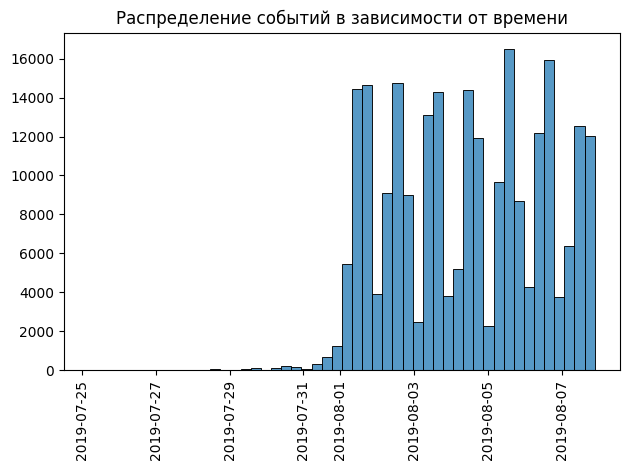

In [15]:
sns.histplot(data['event_time'], bins = 50).set(
                                    title='Распределение событий в зависимости от времени',
                                    xlabel='',                                   
                                    ylabel='')
plt.xticks(rotation=90)
plt.tight_layout()

Как мы видим, данные распределены неравномерно.  
В логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные».   

Судя по гистограмме, полные данные представлены начиная с 1 августа 2019 года.  

Определим исследуемый период в следующем промежутке: **2019-08-01 — 2019-08-07** и отбросим более старые данные:

In [16]:
# сохраним новую минимальную дату исследования:
min_date = '2019-08-01'
min_date = dt.datetime.strptime(min_date, '%Y-%m-%d')

# исключим более старые данные:
data = data[data['event_time'] > min_date]

#### Проверим, сколько событий и пользователей потеряно после того, как отбросили старые данные:

In [17]:
# Подсчет количества событий после удаления старых данных:
print('Количество событий после удаления данных: ', len(data))

# Подсчет количества уникальных пользователей после удаления старых данных:
print('Количество уникальных пользователей после удаления данных: ', data['user_id'].nunique())

print('Доля потерянных событий: {:.1%}'.format(events_total / len(data) -1))
print('Доля потерянных пользователей: {:.1%}'.format(users_total / data['user_id'].nunique()-1))

Количество событий после удаления данных:  240887
Количество уникальных пользователей после удаления данных:  7534
Доля потерянных событий: 1.2%
Доля потерянных пользователей: 0.2%


Количество уникальных пользователей уменьшилось на 17 человек.  
Доля потерянных событий около 1%, доля потерянных пользователей составляет всего 0.2%. Таким образом, можно сделать вывод о том, что влияние потери пользователей на дальнейший анализ будет минимально, либо совсем отсутствовать. 

#### Определим, сколько групп участвовало в A/A/B-тесте:

In [18]:
print('Количество групп в A/A/B-тесте: ', 
      data['exp_id'].nunique())

Количество групп в A/A/B-тесте:  3


#### Посчитаем количество пользователей в каждой группе:

In [19]:
group_amount = data.groupby('exp_id')[['user_id']].nunique().reset_index()
group_amount.columns = ['group', 'users_amount']
group_amount

,group,users_amount
0,246,2484
1,247,2513
2,248,2537


В логах присутсвуют пользователи из всех трёх экспирементальных групп. Количество уникальных пользователей распределено равномерно.   
Проверка качества данных завершена, переходим к основной части исследования. 

## Исследование воронки событий

### Посмотрим, какие события есть в логах и как часто они встречаются:

In [20]:
data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Всего в логах встречаются 5 типов событий:  
- MainScreenAppear – появление главной страницы    
- OffersScreenAppear – появление страницы с товаром  
- CartScreenAppear – пользователь добавил товар в корзину  
- PaymentScreenSuccessful – появление страницы с успешной оплатой  
- Tutorial – прохождение обучения по использованию приложения  

Чаще всего пользователи просматривают главную страницу, второе по частоте событие это просмотр страниц с товарами.  Затем идет  добавление товара в корзину, и меньше всего пользователей проходят обучение по использованию приложения.

### Посчитаем, сколько пользователей совершали каждое из этих событий  

События отсортируем по числу пользователей. Также определим долю пользователей, которые хоть раз совершали событие:

In [21]:
#количество пользователей для каждого события и отсортируем по числу пользователей:
users_amount = data.groupby('event_name').agg(
           {'user_id': 'nunique'}).sort_values(
                                                by='user_id', 
                                                ascending=False).reset_index()
users_amount.columns = ['event_name', 'users_amount']

users_amount['share_of_users'] = round(users_amount['users_amount'] / data['user_id'].nunique() * 100, 1)
users_amount.style.background_gradient(cmap='RdYlGn', subset='share_of_users')

,event_name,users_amount,share_of_users
0,MainScreenAppear,7419,98.500000
1,OffersScreenAppear,4593,61.000000
2,CartScreenAppear,3734,49.600000
3,PaymentScreenSuccessful,3539,47.000000
4,Tutorial,840,11.100000


1.5% пользователей не открывали главную страницу. Около 40% не заходили на страницу товаров. Примерно половина пользователей не добавляла товары в корзину и чуть меньше половины не дошли до оплаты. 88.8% пользователей, посетивших сайт, не открывали страницу Tutorial.   

Событие Tutorial явно связано с заходом на страницу с обучением. Количество таких событий говорит о том, что оно скорее не является обязательным шагом воронки продаж. Предлагаю исключить его из дальнейших расчётов:

In [22]:
data = data[data['event_name'] != 'Tutorial']
users_amount = users_amount[users_amount['event_name'] != 'Tutorial']

Таким образом, путь клиента до совершения покупки выглядит следующим образом:  
1.	Зайти на главную страницу магазина  
2.	Перейти на страницу товара  
3.	Добавить товар в корзину  
4.	Перейти на страницу оформления заказа  
5.	Оплатить заказ  

### Визуализируем воронку событий:

In [33]:
fig = go.Figure(go.Funnel(y = users_amount['event_name'],
                          x = users_amount['users_amount'],
                          opacity = 0.6,
                          textposition = 'inside',
                          textinfo = 'value + percent previous'))
fig.update_layout(title_text='Воронка событий')
fig.show()

### Посчитаем, какая доля пользователей проходит на следующий шаг воронки событий:

In [24]:
import warnings
warnings.simplefilter('ignore')

# считаем конверсию для первого шага
first_step_conversion = users_amount[:1]['users_amount'].values / data['user_id'].nunique() * 100

# считаем конверсию для 2, 3, 4 шагов
users_amount['conversion_by_step'] = [*first_step_conversion] + ((users_amount[1:]['users_amount'].values 
                                / users_amount[: len(users_amount) - 1]['users_amount'].values)*100).tolist()

users_amount.style.background_gradient(cmap='RdYlGn', subset='conversion_by_step')

,event_name,users_amount,share_of_users,conversion_by_step
0,MainScreenAppear,7419,98.500000,98.525896
1,OffersScreenAppear,4593,61.000000,61.908613
2,CartScreenAppear,3734,49.600000,81.297627
3,PaymentScreenSuccessful,3539,47.000000,94.777718


Главную страницу увидели почти все пользователи, зашедшие в приложение.  
Больше всего пользователей теряется на втором шаге воронки: 38% пользователей не доходят с главной страницы до просмотра товаров на сайте.   
До оплаты доходит лишь 47% от изначального количества пользователей. 

In [25]:
# детализируем воронку событий по группам:
funnel_group = (data.
          groupby(['event_name', 'exp_id']).
          agg({'user_id': 'nunique'}).
          reset_index().
          rename(columns={'user_id' : 'total_users'}).
          sort_values(by=['exp_id','total_users'], ascending=False))

funnel_group = funnel_group[funnel_group['event_name'] != 'Tutorial']
funnel_group

,event_name,exp_id,total_users
5,MainScreenAppear,248,2493
8,OffersScreenAppear,248,1531
2,CartScreenAppear,248,1230
11,PaymentScreenSuccessful,248,1181
4,MainScreenAppear,247,2476
7,OffersScreenAppear,247,1520
1,CartScreenAppear,247,1238
10,PaymentScreenSuccessful,247,1158
3,MainScreenAppear,246,2450
6,OffersScreenAppear,246,1542


## Исследование результатов эксперимента

Ранее мы выяснили, что в каждой экспериментальной группе ≈ 2500 уникальных пользователей.  
Построим распределение количества пользователей по группам:

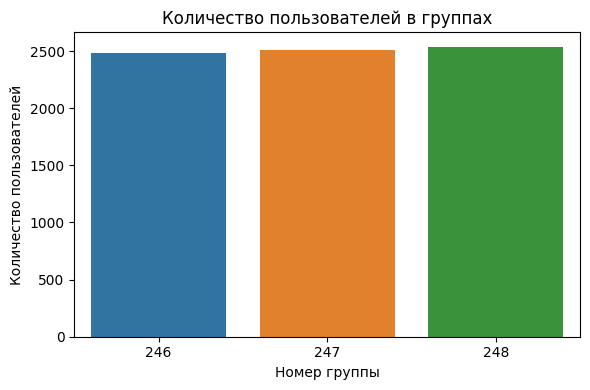

In [26]:
plt.figure(figsize=(6,4))
sns.barplot(data=group_amount, x='group', y='users_amount').set(
        title= f'Количество пользователей в группах',
        xlabel='Номер группы',
        ylabel='Количество пользователей'
)
plt.tight_layout()

Во всех трех группах примерно одинаковое количество пользователей и их число является удовлетсворительным для проведения тестирования.  

В A/B-тестировании чаще всего проверяют гипотезу о равенстве пропорций в сравниваемых генеральных совокупностях.  
У нас имеется 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов.  

### Проверим, находят ли статистические критерии разницу между выборками 246 и 247 для каждого из событий воронки:  

Для проверки воспользуемся Z-критерием (статистический тест, позволяющий определить, различаются ли два средних значения генеральной совокупности, когда дисперсии известны и размер выборки велик).   

Также при тестировании применим поправку Бонферрони. Поправка применяется для того, чтобы застраховать себя от ложного результата, когда проводим множественное сравнение. 
Всего у нас 4 вида событий, 4 A/A теста и 12 А/В, следовательно *bonferroni_alpha* = *alpha* / 16 (заданный уровень статистической значимости *alpha* делим на суммарное количество тестов).

Сформулируем гипотезы:  
**Н0:** Конверсия пользователей в группах 246 и 247 равна    
**Н1:** Конверсия пользователей в группах 246 и 247 не равна    

In [27]:
# напишем функцию для удобства дальнейшего тестирования:
def z_test(df1, df2, event, alpha, n):
    
    # критический уровень статистической значимости c поправкой Бонферрони
    bonferroni_alpha = alpha / n
 
    # число пользователей в группе 1 и группе 2:
    n_users = np.array([df1['user_id'].nunique(), 
                        df2['user_id'].nunique()])

    # число пользователей, совершивших событие в группе 1 и группе 2
    success = np.array([df1[df1['event_name'] == event]['user_id'].nunique(), 
                        df2[df2['event_name'] == event]['user_id'].nunique()])

    # пропорции успехов в группах:
    p1 = success[0]/n_users[0]
    p2 = success[1]/n_users[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2   #тест двусторонний, удваиваем результат
    
    print('Событие:', event)
    print('p-значение: ', p_value)

    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [28]:
# проверим, есть ли статистически значимая разница между контрольными группами 246 и 247:
for event in funnel_group['event_name'].unique():
    z_test(data[data['exp_id'] == 246], data[data['exp_id'] == 247], event,.05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Главная цель А/А-теста — показать, можно ли доверять результатам эксперимента, который будет запущен в тех же условиях, но уже с разными вариантами шрифта. Если в ходе А/А-теста победителя выявить не удалось, можно запускать А/B-тест.

4 z-теста для контрольных групп 246 и 247 не выявили статистически значимой разницы между между ними.  
Таким образом, можно сделать вывод, что разделение на группы было проведено корректно и можно приступать к A/B-тестированию.

### Проверим, есть ли статистически значимая разница между группами 246 и 248:

Сформулируем гипотезы для всех дальнейших попарных сравнений:  
**Н0:** Конверсии пользователей в сравниваемых группах равны   
**Н1:** Конверсии пользователей в сравниваемых группах не равны    

In [29]:
# разница конверсии между группами 246 и 248:
for event in funnel_group['event_name'].unique():
    z_test(data[data['exp_id'] == 246], data[data['exp_id'] == 248], event, .05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



### Проверим, есть ли статистически значимая разница между группами 247 и 248:

In [30]:
# разница конверсии между группами 247 и 248:
for event in funnel_group['event_name'].unique():
    z_test(data[data['exp_id'] == 247], data[data['exp_id'] == 248], event,.05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



### Проверим, есть ли статистически значимая разница между объединённой контрольной и экпериментальной 248 группами:

In [31]:
# разница конверсии между объединённой контрольной и экпериментальной 248 группами:
for event in funnel_group['event_name'].unique():
    z_test(data[data['exp_id'] != 248], data[data['exp_id'] == 248], event,.05, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



A/A/B тестирование всех групп в разрезе каждого из событий, включая объединенные контрольные группы 246 и 247, не выявило статистически значимых различий между группами. Это означает, что изменение шрифтов в приложении никак не повлияло на конверсию пользователей.

## Рекомендации и выводы  

Результаты тестирования показали, что новый шрифт никак не повлиял на поведение пользователей - конверсия осталась на прежнем уровне.  

Общий анализ данных показал, что самым популярным событияем является просмотр главной страницы сайта ('MainScreenAppear').  
    Больше всего теряется пользователей после перехода с главной страницы на страницу товара - и далее в корзину. Из корзины до полной оплаты "потерялось" менее 3% пользователей. От первого события до оплаты доходит всего 47% пользователей. Это напрямую связано с большим провалом на первом шаге: при переходе с главной страницы (событие *MainScreenAppear*) к странице с товарами (событие *OffersScreenAppear*). Вероятно, нужно лучше прорабатывать механику удержания, чтобы пользователи охотнее переходили к просмотру товаров.

Наименьшее число пользователей доходит до раздела *Tutorial*. Возможно, ссылка на раздел находится в неудобном или незаметном месте. Пользователи либо не знают куда заходить, либо не понимают ценность обучения - нужно обратить внимание на данный раздел.